# PRÁCTICA 2: Reconocimiento de Actividades con Sensores Inerciales
## Modelos Avanzados de Aprendizaje Automático I (2025/26)

In [3]:
# ====================================================================================
# 0. LIBRERÍAS Y CONFIGURACIÓN
# ====================================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding as LLE
from sklearn.feature_selection import f_classif, SelectKBest, RFE, mutual_info_classif

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier, AdaBoostClassifier, RandomForestClassifier,
    VotingClassifier, StackingClassifier
)

try:
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cb
    HAS_BOOSTING = True
except:
    print("⚠ Paquetes de Boosting no disponibles")
    HAS_BOOSTING = False

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(104)
print("✓ Librerías cargadas")

⚠ Paquetes de Boosting no disponibles
✓ Librerías cargadas


## 1. PREPARACIÓN DE DATOS (20%)

In [4]:
# 1.1 CARGA Y UNIFICACIÓN DE DATOS
print("="*70)
print("1. CARGA Y UNIFICACIÓN DE DATOS")
print("="*70)

base_path = r"c:\Users\ivanm\OneDrive - Universidade da Coruña\Año4\MAAI\p2\practice2\Datos Práctica"
inv_a_path = os.path.join(base_path, "Investigador A")
inv_b_path = os.path.join(base_path, "Investigador B")

# Cargar Investigador A (por días)
dfs_inv_a = []
for day in range(1, 6):
    day_path = os.path.join(inv_a_path, f"day {day}")
    if os.path.exists(day_path):
        for file in os.listdir(day_path):
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(day_path, file))
                df['subject_id'] = int(file.replace('Sujeto_', '').replace('.csv', ''))
                df['day'] = day
                df['researcher'] = 'A'
                dfs_inv_a.append(df)

# Cargar Investigador B
dfs_inv_b = []
for file in os.listdir(inv_b_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(inv_b_path, file))
        df['subject_id'] = int(file.replace('Sujeto_', '').replace('.csv', ''))
        df['day'] = -1
        df['researcher'] = 'B'
        dfs_inv_b.append(df)

# Unificar
data = pd.concat(dfs_inv_a + dfs_inv_b, ignore_index=True)

print(f"\n✓ Datos cargados:")
print(f"  Instancias: {data.shape[0]:,}")
print(f"  Variables: {data.shape[1]}")
print(f"  Individuos: {data['subject_id'].nunique()}")
print(f"\nColumnas: {list(data.columns)[:10]}...")
print(f"\nPrimeras 3 filas:\n{data.head(3)}")

1. CARGA Y UNIFICACIÓN DE DATOS

✓ Datos cargados:
  Instancias: 10,299
  Variables: 566
  Individuos: 30

Columnas: ['subject', 'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z']...

Primeras 3 filas:
   subject  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0        1           0.288585          -0.020294          -0.132905   
1        1           0.274262          -0.012265          -0.109494   
2        1           0.277258          -0.014249          -0.112205   

   tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0         -0.995279         -0.983111         -0.913526         -0.995112   
1         -0.993865         -0.977421         -0.989336         -0.995502   
2         -0.997016         -0.977680         -0.997140         -0.997566   

   tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  ...  \
0         -0.983185       

In [5]:
# 1.2 ANÁLISIS DE VALORES AUSENTES
print("\n" + "="*70)
print("2. ANÁLISIS DE VALORES AUSENTES")
print("="*70)

null_pct = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
null_pct = null_pct[null_pct > 0]

total_nulls = data.isnull().sum().sum()
global_pct = total_nulls / (data.shape[0] * data.shape[1]) * 100

print(f"\nTotal de nulos: {total_nulls}")
print(f"Porcentaje global: {global_pct:.2f}%")
print(f"\nTop 10 variables con nulos:")
if len(null_pct) > 0:
    for col, pct in null_pct.head(10).items():
        print(f"  {col}: {pct:.2f}%")
else:
    print("  No hay valores ausentes")


2. ANÁLISIS DE VALORES AUSENTES

Total de nulos: 57892
Porcentaje global: 0.99%

Top 10 variables con nulos:
  tBodyGyroMag-mad(): 10.03%
  tBodyGyroMag-iqr(): 10.03%
  fBodyAcc-mad()-Y: 10.02%
  fBodyAccJerk-mean()-X: 10.02%
  tBodyAccJerk-entropy()-Y: 10.00%
  tGravityAccMag-entropy(): 10.00%
  tGravityAccMag-std(): 10.00%
  fBodyBodyGyroMag-iqr(): 10.00%
  tBodyAccMag-max(): 10.00%
  tBodyAccJerk-energy()-X: 10.00%


In [6]:
# 1.3 TRATAMIENTO Y TRANSFORMACIÓN
print("\n" + "="*70)
print("3. TRATAMIENTO Y TRANSFORMACIÓN")
print("="*70)

# Separar features y target
# Buscar columna de actividad
activity_col = None
for col in data.columns:
    if col.upper() in ['ACTIVITY', 'CLASE', 'CLASS', 'LABEL']:
        activity_col = col
        break

if activity_col is None:
    # Buscar columna con pocas categorías únicas
    for col in data.columns:
        if data[col].nunique() < 10 and data[col].dtype == 'object':
            activity_col = col
            break

if activity_col is None:
    # Usar última columna
    activity_col = data.columns[-1]

print(f"Columna de actividad: {activity_col}")
print(f"Clases: {data[activity_col].unique()[:10]}...")

y = data[activity_col].copy()
X = data.drop(columns=[activity_col, 'subject_id', 'day', 'researcher'])
subject_ids = data['subject_id'].values

# Eliminar filas con todos nulos
X = X.dropna(how='all')
y = y[X.index].reset_index(drop=True)
subject_ids = subject_ids[X.index]
X = X.reset_index(drop=True)

# Imputar con media
X = X.fillna(X.mean())

# Codificar clases
if y.dtype == 'object':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), index=y.index)
    class_names = le.classes_
    print(f"\nClases codificadas:")
    for i, name in enumerate(class_names):
        print(f"  {i}: {name}")
else:
    class_names = np.unique(y)

print(f"\n✓ Features: {X.shape[1]}, Instancias: {X.shape[0]}, Clases: {len(class_names)}")


3. TRATAMIENTO Y TRANSFORMACIÓN
Columna de actividad: Activity
Clases: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_UPSTAIRS'
 'WALKING_DOWNSTAIRS']...

Clases codificadas:
  0: LAYING
  1: SITTING
  2: STANDING
  3: WALKING
  4: WALKING_DOWNSTAIRS
  5: WALKING_UPSTAIRS

✓ Features: 562, Instancias: 10299, Clases: 6


In [7]:
# 1.4 PARTICIÓN HOLDOUT (10% test)
print("\n" + "="*70)
print("4. PARTICIÓN HOLDOUT (10% test)")
print("="*70)

unique_subjects = np.unique(subject_ids)
n_test_subjects = max(1, int(np.ceil(len(unique_subjects) * 0.1)))
test_subjects = np.random.choice(unique_subjects, size=n_test_subjects, replace=False)

test_mask = np.isin(subject_ids, test_subjects)
train_mask = ~test_mask

X_train = X[train_mask].reset_index(drop=True)
y_train = y[train_mask].reset_index(drop=True)
X_test = X[test_mask].reset_index(drop=True)
y_test = y[test_mask].reset_index(drop=True)
subject_train = subject_ids[train_mask]
subject_test = subject_ids[test_mask]

print(f"\nTotal de sujetos: {len(unique_subjects)}")
print(f"Sujetos en test (10%): {len(test_subjects)} → {sorted(test_subjects)}")
print(f"Sujetos en train: {len(unique_subjects) - len(test_subjects)}")
print(f"\nInstancias train: {X_train.shape[0]}")
print(f"Instancias test: {X_test.shape[0]}")


4. PARTICIÓN HOLDOUT (10% test)

Total de sujetos: 30
Sujetos en test (10%): 3 → [np.int64(19), np.int64(23), np.int64(28)]
Sujetos en train: 27

Instancias train: 9185
Instancias test: 1114


In [8]:
# 1.5 VALIDACIÓN CRUZADA INDIVIDUAL-WISE (5-Fold)
print("\n" + "="*70)
print("5. VALIDACIÓN CRUZADA INDIVIDUAL-WISE (5-Fold)")
print("="*70)

unique_train_subjects = np.unique(subject_train)
n_folds = 5
n_per_fold = len(unique_train_subjects) // n_folds

fold_indices = np.random.permutation(len(unique_train_subjects))

cv_folds = []
for fold in range(n_folds):
    start = fold * n_per_fold
    end = start + n_per_fold if fold < n_folds - 1 else len(unique_train_subjects)
    fold_subjects = unique_train_subjects[fold_indices[start:end]]
    
    val_idx = np.where(np.isin(subject_train, fold_subjects))[0]
    train_idx = np.where(~np.isin(subject_train, fold_subjects))[0]
    
    cv_folds.append((train_idx, val_idx))
    print(f"Fold {fold+1}: Train={len(train_idx):4d}, Val={len(val_idx):4d}")

print(f"\n✓ CV creada: {len(cv_folds)}-Fold")


5. VALIDACIÓN CRUZADA INDIVIDUAL-WISE (5-Fold)
Fold 1: Train=7585, Val=1600
Fold 2: Train=7443, Val=1742
Fold 3: Train=7429, Val=1756
Fold 4: Train=7443, Val=1742
Fold 5: Train=6840, Val=2345

✓ CV creada: 5-Fold


In [9]:
# 1.6 NORMALIZACIÓN MIN-MAX SCALING
print("\n" + "="*70)
print("6. NORMALIZACIÓN MIN-MAX SCALING")
print("="*70)

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print(f"\n✓ Datos normalizados [0, 1]")
print(f"  Train: {X_train_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")
print(f"  Rango: [{X_train_scaled.min().min():.4f}, {X_train_scaled.max().max():.4f}]")


6. NORMALIZACIÓN MIN-MAX SCALING

✓ Datos normalizados [0, 1]
  Train: (9185, 562)
  Test: (1114, 562)
  Rango: [0.0000, 1.0000]


In [10]:
# ====================================================================================
# FUNCIONES AUXILIARES
# ====================================================================================

def apply_feature_selection(X_tr, X_te, y_tr, method='none', n_feat=50):
    """Selecciona características"""
    if method == 'none':
        return X_tr, X_te, X_tr.columns.tolist()
    
    k = min(n_feat, X_tr.shape[1])
    
    if method == 'anova':
        sel = SelectKBest(f_classif, k=k)
    elif method == 'mi':
        sel = SelectKBest(mutual_info_classif, k=k)
    elif method == 'rfe':
        lr = LogisticRegression(max_iter=1000, random_state=104)
        sel = RFE(lr, n_features_to_select=k, step=max(1, k//2))
    else:
        return X_tr, X_te, X_tr.columns.tolist()
    
    sel.fit(X_tr, y_tr)
    mask = sel.get_support()
    cols = [c for c, m in zip(X_tr.columns, mask) if m]
    return X_tr[cols], X_te[cols], cols

def apply_projection(X_tr, X_te, y_tr, method='pca', n_comp=30):
    """Proyecta a dimensión inferior"""
    if method == 'none':
        return X_tr, X_te
    
    n_comp = min(n_comp, X_tr.shape[1] - 1, X_tr.shape[0] - 1)
    
    if method == 'pca':
        proj = PCA(n_components=n_comp, random_state=104)
        Xtr_p = proj.fit_transform(X_tr)
        Xte_p = proj.transform(X_te)
    elif method == 'ica':
        proj = FastICA(n_components=n_comp, random_state=104, max_iter=500)
        Xtr_p = proj.fit_transform(X_tr)
        Xte_p = proj.transform(X_te)
    elif method == 'lda':
        # LDA necesita y
        n_comp_lda = min(n_comp, len(np.unique(y_tr)) - 1)
        proj = LDA(n_components=n_comp_lda)
        Xtr_p = proj.fit_transform(X_tr, y_tr)
        Xte_p = proj.transform(X_te)
    else:
        return X_tr, X_te
    
    return Xtr_p, Xte_p

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


## 2. MODELOS BÁSICOS (20%)

In [11]:
# ENTRENAMIENTO DE MODELOS BASE (9 combinaciones)
print("\n" + "="*70)
print("ENTRENAMIENTO DE MODELOS BASE")
print("="*70)

# 9 configuraciones: 3 filtros × 3 proyecciones × 3 clasificadores
configs = [
    # (filtro, proyección, clasificador, parámetros, nombre)
    ('none', 'none', 'mlp', {'hidden_layer_sizes': (50,)}, 'MLP-50'),
    ('none', 'none', 'knn', {'n_neighbors': 1}, 'KNN-1'),
    ('none', 'none', 'svc', {'C': 0.1}, 'SVC-0.1'),
    
    ('anova', 'pca', 'mlp', {'hidden_layer_sizes': (100, 50)}, 'MLP-100-50-ANOVA-PCA'),
    ('anova', 'pca', 'knn', {'n_neighbors': 10}, 'KNN-10-ANOVA-PCA'),
    ('anova', 'pca', 'svc', {'C': 0.5}, 'SVC-0.5-ANOVA-PCA'),
    
    ('mi', 'lda', 'mlp', {'hidden_layer_sizes': (100,)}, 'MLP-100-MI-LDA'),
    ('mi', 'lda', 'knn', {'n_neighbors': 20}, 'KNN-20-MI-LDA'),
    ('mi', 'lda', 'svc', {'C': 1.0}, 'SVC-1.0-MI-LDA'),
]

results_base = []

for filt, proj, ctype, cparams, name in configs:
    print(f"\n{name}...", end=" ", flush=True)
    accs = []
    
    for tr_idx, val_idx in cv_folds:
        # Datos de train/validación
        Xtr = X_train_scaled.iloc[tr_idx].reset_index(drop=True)
        ytr = y_train.iloc[tr_idx].reset_index(drop=True)
        Xval = X_train_scaled.iloc[val_idx].reset_index(drop=True)
        yval = y_train.iloc[val_idx].reset_index(drop=True)
        
        # Seleccionar features
        Xtr_fs, Xval_fs, _ = apply_feature_selection(Xtr, Xval, ytr, filt, 50)
        
        # Proyectar
        Xtr_p, Xval_p = apply_projection(Xtr_fs, Xval_fs, ytr, proj, 30)
        
        # Entrenar clasificador
        if ctype == 'mlp':
            clf = MLPClassifier(random_state=104, max_iter=500, **cparams)
        elif ctype == 'knn':
            clf = KNeighborsClassifier(**cparams)
        else:  # svc
            clf = SVC(kernel='rbf', random_state=104, **cparams)
        
        clf.fit(Xtr_p, ytr)
        acc = clf.score(Xval_p, yval)
        accs.append(acc)
    
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    results_base.append({
        'model': name,
        'filtro': filt,
        'proyección': proj,
        'clasificador': ctype,
        'mean_acc': mean_acc,
        'std_acc': std_acc
    })
    print(f"{mean_acc:.4f} ± {std_acc:.4f}")

# Resultados
df_base = pd.DataFrame(results_base).sort_values('mean_acc', ascending=False)
print("\n" + "="*70)
print("TOP 5 MODELOS BASE (5-Fold CV)")
print("="*70)
for i, (_, row) in enumerate(df_base.head(5).iterrows(), 1):
    print(f"{i}. {row['model']:40s} {row['mean_acc']:.4f} ± {row['std_acc']:.4f}")


ENTRENAMIENTO DE MODELOS BASE

MLP-50... 0.9370 ± 0.0240

KNN-1... 0.9370 ± 0.0240

KNN-1... 0.8783 ± 0.0142

SVC-0.1... 0.8783 ± 0.0142

SVC-0.1... 0.8998 ± 0.0278

MLP-100-50-ANOVA-PCA... 0.8998 ± 0.0278

MLP-100-50-ANOVA-PCA... 0.9067 ± 0.0310

KNN-10-ANOVA-PCA... 0.9067 ± 0.0310

KNN-10-ANOVA-PCA... 0.8321 ± 0.0309

SVC-0.5-ANOVA-PCA... 0.8321 ± 0.0309

SVC-0.5-ANOVA-PCA... 0.8385 ± 0.0351

MLP-100-MI-LDA... 0.8385 ± 0.0351

MLP-100-MI-LDA... 0.9000 ± 0.0413

KNN-20-MI-LDA... 0.9000 ± 0.0413

KNN-20-MI-LDA... 0.8851 ± 0.0370

SVC-1.0-MI-LDA... 0.8851 ± 0.0370

SVC-1.0-MI-LDA... 0.8930 ± 0.0412

TOP 5 MODELOS BASE (5-Fold CV)
1. MLP-50                                   0.9370 ± 0.0240
2. MLP-100-50-ANOVA-PCA                     0.9067 ± 0.0310
3. MLP-100-MI-LDA                           0.9000 ± 0.0413
4. SVC-0.1                                  0.8998 ± 0.0278
5. SVC-1.0-MI-LDA                           0.8930 ± 0.0412
0.8930 ± 0.0412

TOP 5 MODELOS BASE (5-Fold CV)
1. MLP-50     

## 3. MODELOS ENSEMBLE (30%)

In [12]:
# PCA global
print("\n" + "="*70)
print("ENTRENAMIENTO DE MODELOS ENSEMBLE")
print("="*70)

pca_global = PCA(n_components=0.95, random_state=104)
X_train_pca = pca_global.fit_transform(X_train_scaled)
X_test_pca = pca_global.transform(X_test_scaled)
n_pca = X_train_pca.shape[1]

print(f"\nPCA: {X_train_scaled.shape[1]} → {n_pca} (95% var)")

results_ens = []

# Bagging
for n_est in [10, 50]:
    name = f'Bagging-{n_est}'
    print(f"\n{name}...", end=" ", flush=True)
    accs = []
    
    for tr_idx, val_idx in cv_folds:
        Xtr_pca = X_train_pca[tr_idx]
        ytr = y_train.iloc[tr_idx].reset_index(drop=True)
        Xval_pca = X_train_pca[val_idx]
        yval = y_train.iloc[val_idx].reset_index(drop=True)
        
        clf = BaggingClassifier(
            estimator=KNeighborsClassifier(n_neighbors=5),
            n_estimators=n_est, random_state=104
        )
        clf.fit(Xtr_pca, ytr)
        acc = clf.score(Xval_pca, yval)
        accs.append(acc)
    
    mean_acc = np.mean(accs)
    results_ens.append({'model': name, 'type': 'Bagging', 'mean_acc': mean_acc})
    print(f"{mean_acc:.4f}")

# AdaBoost
name = 'AdaBoost-5'
print(f"\n{name}...", end=" ", flush=True)
accs = []

for tr_idx, val_idx in cv_folds:
    Xtr_pca = X_train_pca[tr_idx]
    ytr = y_train.iloc[tr_idx].reset_index(drop=True)
    Xval_pca = X_train_pca[val_idx]
    yval = y_train.iloc[val_idx].reset_index(drop=True)
    
    clf = AdaBoostClassifier(
        estimator=SVC(kernel='linear', C=0.5, random_state=104),
        n_estimators=5, random_state=104
    )
    clf.fit(Xtr_pca, ytr)
    acc = clf.score(Xval_pca, yval)
    accs.append(acc)

mean_acc = np.mean(accs)
results_ens.append({'model': name, 'type': 'AdaBoost', 'mean_acc': mean_acc})
print(f"{mean_acc:.4f}")

# Random Forest
name = 'RandomForest-500'
print(f"\n{name}...", end=" ", flush=True)
accs = []

for tr_idx, val_idx in cv_folds:
    Xtr_pca = X_train_pca[tr_idx]
    ytr = y_train.iloc[tr_idx].reset_index(drop=True)
    Xval_pca = X_train_pca[val_idx]
    yval = y_train.iloc[val_idx].reset_index(drop=True)
    
    clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=104, n_jobs=-1)
    clf.fit(Xtr_pca, ytr)
    acc = clf.score(Xval_pca, yval)
    accs.append(acc)

mean_acc = np.mean(accs)
results_ens.append({'model': name, 'type': 'RF', 'mean_acc': mean_acc})
print(f"{mean_acc:.4f}")

df_ens = pd.DataFrame(results_ens).sort_values('mean_acc', ascending=False)
print("\nModelos Ensemble:")
for _, row in df_ens.iterrows():
    print(f"  {row['model']:30s} {row['mean_acc']:.4f}")


ENTRENAMIENTO DE MODELOS ENSEMBLE

PCA: 562 → 75 (95% var)

Bagging-10... 0.8937

Bagging-50... 0.8937

Bagging-50... 0.8947

AdaBoost-5... 0.8947

AdaBoost-5... 0.3462

RandomForest-500... 0.3462

RandomForest-500... 0.8743

Modelos Ensemble:
  Bagging-50                     0.8947
  Bagging-10                     0.8937
  RandomForest-500               0.8743
  AdaBoost-5                     0.3462
0.8743

Modelos Ensemble:
  Bagging-50                     0.8947
  Bagging-10                     0.8937
  RandomForest-500               0.8743
  AdaBoost-5                     0.3462


## 4. VISUALIZACIÓN (10%)


VISUALIZACIONES 2D
PCA... LDA... ICA... t-SNE... Isomap... LLE... 

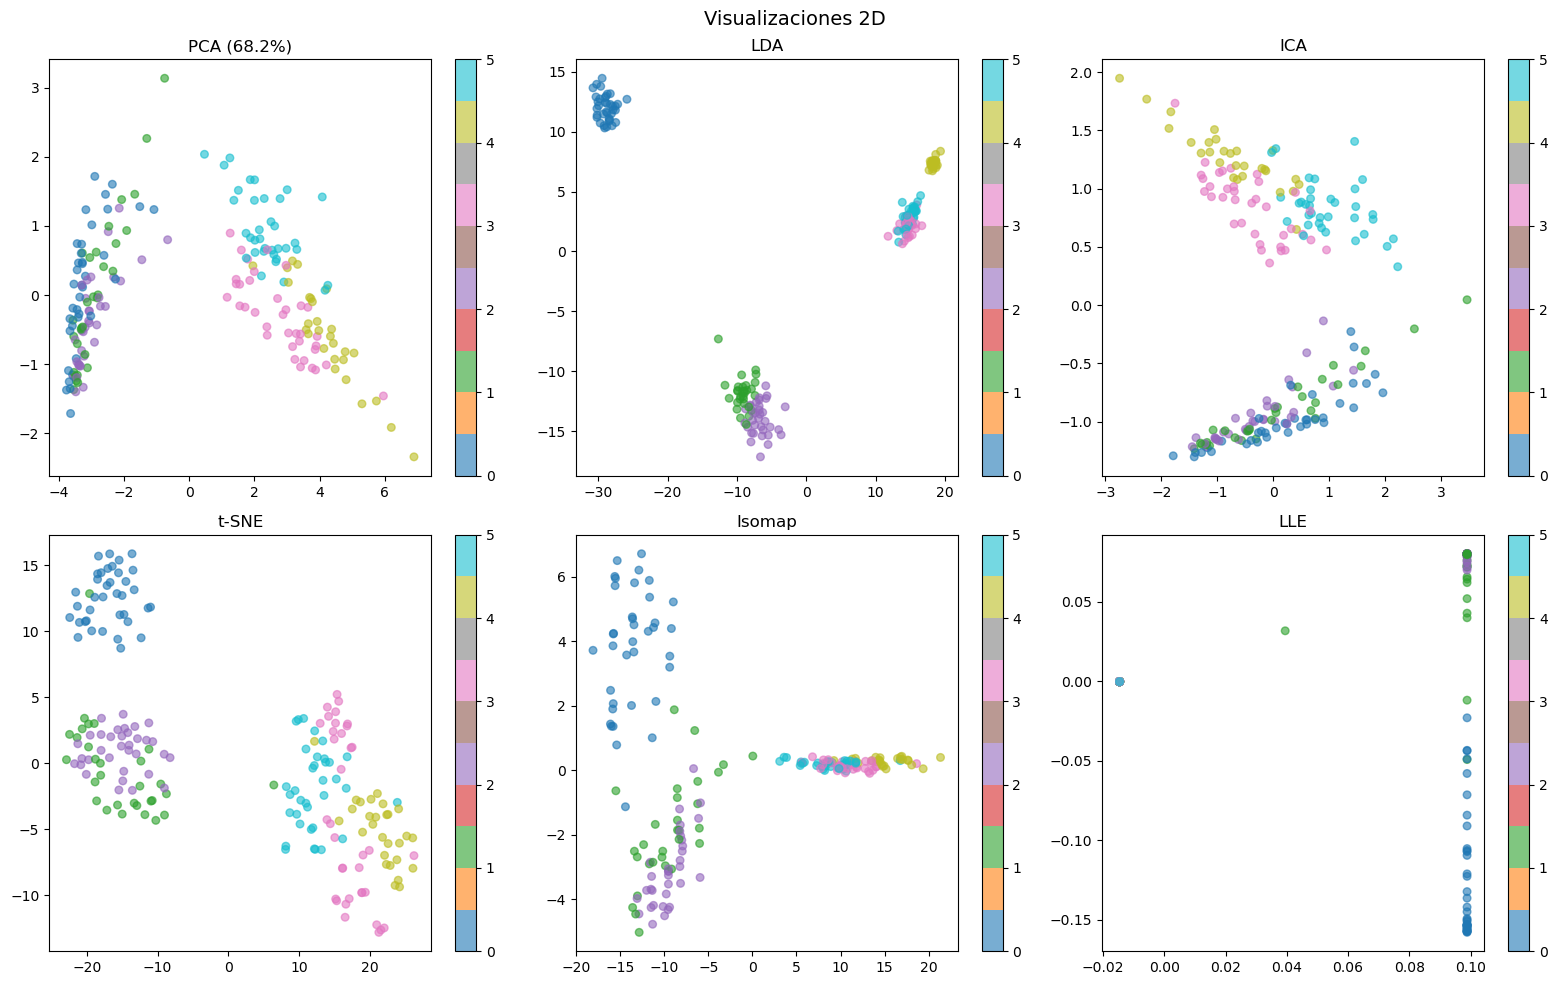

✓


In [19]:
print("\n" + "="*70)
print("VISUALIZACIONES 2D")
print("="*70)

# Muestra más pequeña para acelerar
n_sample = min(200, X_train_scaled.shape[0])  # en lugar de 500
idx_sample = np.random.choice(X_train_scaled.shape[0], n_sample, replace=False)
X_sample = X_train_scaled.iloc[idx_sample]
y_sample = y_train.iloc[idx_sample]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Visualizaciones 2D', fontsize=14)

# PCA
print("PCA...", end=" ", flush=True)
pca = PCA(n_components=2, random_state=104)
X_pca = pca.fit_transform(X_sample)
scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=30)
axes[0, 0].set_title(f'PCA ({pca.explained_variance_ratio_.sum():.1%})')
plt.colorbar(scatter, ax=axes[0, 0])

# LDA
print("LDA...", end=" ", flush=True)
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_sample, y_sample)
scatter = axes[0, 1].scatter(X_lda[:, 0], X_lda[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=30)
axes[0, 1].set_title('LDA')
plt.colorbar(scatter, ax=axes[0, 1])

# ICA
print("ICA...", end=" ", flush=True)
ica = FastICA(n_components=2, random_state=104, max_iter=300)
X_ica = ica.fit_transform(X_sample)
scatter = axes[0, 2].scatter(X_ica[:, 0], X_ica[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=30)
axes[0, 2].set_title('ICA')
plt.colorbar(scatter, ax=axes[0, 2])

# t-SNE (más rápido si reduces iteraciones)
print("t-SNE...", end=" ", flush=True)
X_tsne = TSNE(n_components=2, random_state=104, max_iter=500, perplexity=20).fit_transform(X_sample)

scatter = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=30)
axes[1, 0].set_title('t-SNE')
plt.colorbar(scatter, ax=axes[1, 0])

# Isomap
print("Isomap...", end=" ", flush=True)
X_iso = Isomap(n_components=2, n_neighbors=5).fit_transform(X_sample)
scatter = axes[1, 1].scatter(X_iso[:, 0], X_iso[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=30)
axes[1, 1].set_title('Isomap')
plt.colorbar(scatter, ax=axes[1, 1])

# LLE
print("LLE...", end=" ", flush=True)
X_lle = LLE(n_components=2, n_neighbors=5).fit_transform(X_sample)
scatter = axes[1, 2].scatter(X_lle[:, 0], X_lle[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=30)
axes[1, 2].set_title('LLE')
plt.colorbar(scatter, ax=axes[1, 2])

plt.tight_layout()
plt.show()
print("✓")


## 5. IMPORTANCIA DE VARIABLES (10%)


IMPORTANCIA DE VARIABLES

Random Forest... ✓


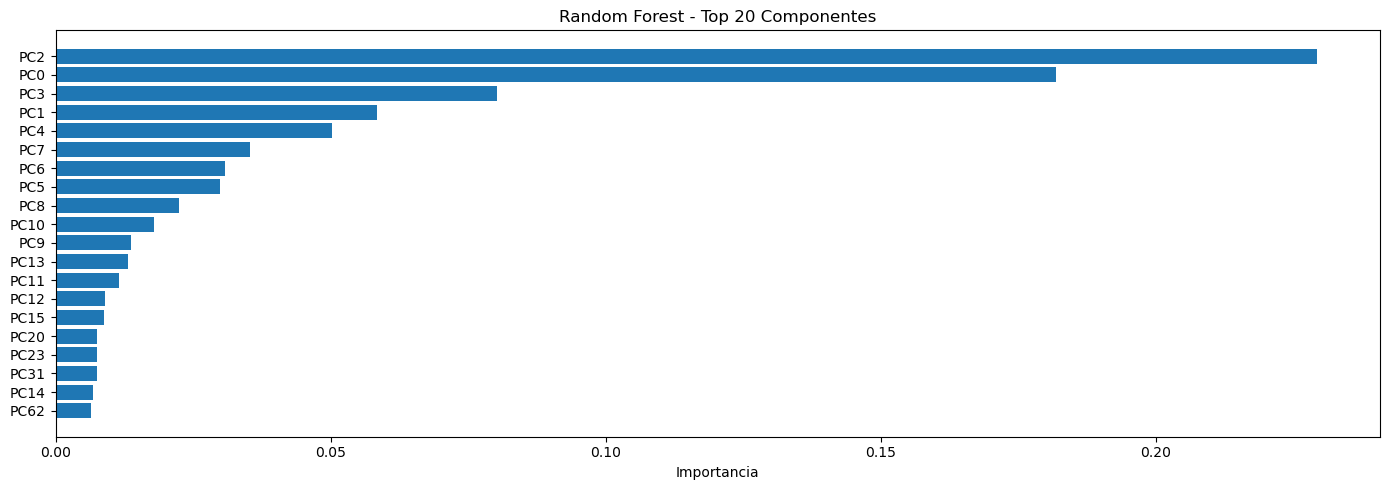

✓ Importancias completadas


In [20]:
print("\n" + "="*70)
print("IMPORTANCIA DE VARIABLES")
print("="*70)

# Random Forest
print("\nRandom Forest...", end=" ", flush=True)
rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=104, n_jobs=-1)
rf.fit(X_train_pca, y_train)
rf_imp = rf.feature_importances_
print("✓")

# XGBoost
xgb_imp = None
if HAS_BOOSTING:
    try:
        print("XGBoost...", end=" ", flush=True)
        xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=104, use_label_encoder=False, eval_metric='mlogloss')
        xgb_model.fit(X_train_pca, y_train, verbose=False)
        xgb_imp = xgb_model.feature_importances_
        print("✓")
    except:
        print("Error")

# Plot
fig, axes = plt.subplots(1, 2 if xgb_imp is not None else 1, figsize=(14, 5))

top_n = 20
top_idx = np.argsort(rf_imp)[-top_n:]

if xgb_imp is not None:
    ax = axes[0]
else:
    ax = axes

ax.barh(range(top_n), rf_imp[top_idx])
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'PC{i}' for i in top_idx])
ax.set_xlabel('Importancia')
ax.set_title('Random Forest - Top 20 Componentes')

if xgb_imp is not None:
    top_idx_xgb = np.argsort(xgb_imp)[-top_n:]
    axes[1].barh(range(top_n), xgb_imp[top_idx_xgb])
    axes[1].set_yticks(range(top_n))
    axes[1].set_yticklabels([f'PC{i}' for i in top_idx_xgb])
    axes[1].set_xlabel('Importancia')
    axes[1].set_title('XGBoost - Top 20 Componentes')

plt.tight_layout()
plt.show()
print("✓ Importancias completadas")

## 6. RESULTADOS FINALES

In [22]:
# Evaluación en test set del mejor modelo base
print("\n" + "="*70)
print("EVALUACIÓN EN TEST SET")
print("="*70)

# Mejor modelo base
best_base = df_base.iloc[0]
print(f"\nMejor modelo base: {best_base['model']}")
print(f"Accuracy CV: {best_base['mean_acc']:.4f} ± {best_base['std_acc']:.4f}")

# Reentrenar en todo train set
Xtr_fs, Xte_fs, selector = apply_feature_selection(
    X_train_scaled, X_test_scaled, y_train, best_base['filtro'], 50
)
Xtr_p, Xte_p = apply_projection(Xtr_fs, Xte_fs, y_train, best_base['proyección'], 30)

if best_base['clasificador'] == 'mlp':
    clf = MLPClassifier(random_state=104, max_iter=500)
elif best_base['clasificador'] == 'knn':
    clf = KNeighborsClassifier(n_neighbors=int(best_base['model'].split('-')[1]))
else:
    clf = SVC(kernel='rbf', random_state=104)

clf.fit(Xtr_p, y_train)
test_acc_base = clf.score(Xte_p, y_test)
print(f"Accuracy Test: {test_acc_base:.4f}")


# Mejor modelo ensemble
best_ens = df_ens.iloc[0]
print(f"\nMejor modelo ensemble: {best_ens['model']}")
print(f"Accuracy CV: {best_ens['mean_acc']:.4f}")

# Reentrenar en todo train set con PCA global
if 'Bagging' in best_ens['model']:
    clf_ens = BaggingClassifier(
        estimator=KNeighborsClassifier(n_neighbors=5),
        n_estimators=int(best_ens['model'].split('-')[1]),
        random_state=104
    )
elif 'AdaBoost' in best_ens['model']:
    clf_ens = AdaBoostClassifier(
        estimator=SVC(kernel='linear', C=0.5, random_state=104),
        n_estimators=5, random_state=104
    )
else:  # RandomForest
    clf_ens = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=104, n_jobs=-1)

clf_ens.fit(X_train_pca, y_train)
test_acc_ens = clf_ens.score(X_test_pca, y_test)
print(f"Accuracy Test: {test_acc_ens:.4f}")

print("\n" + "="*70)
print("COMPARATIVA FINAL")
print("="*70)
print(f"Mejor Base vs Mejor Ensemble: {test_acc_base:.4f} vs {test_acc_ens:.4f}")


EVALUACIÓN EN TEST SET

Mejor modelo base: MLP-50
Accuracy CV: 0.9370 ± 0.0240
Accuracy Test: 0.9551

Mejor modelo ensemble: Bagging-50
Accuracy CV: 0.8947
Accuracy Test: 0.8725

COMPARATIVA FINAL
Mejor Base vs Mejor Ensemble: 0.9551 vs 0.8725


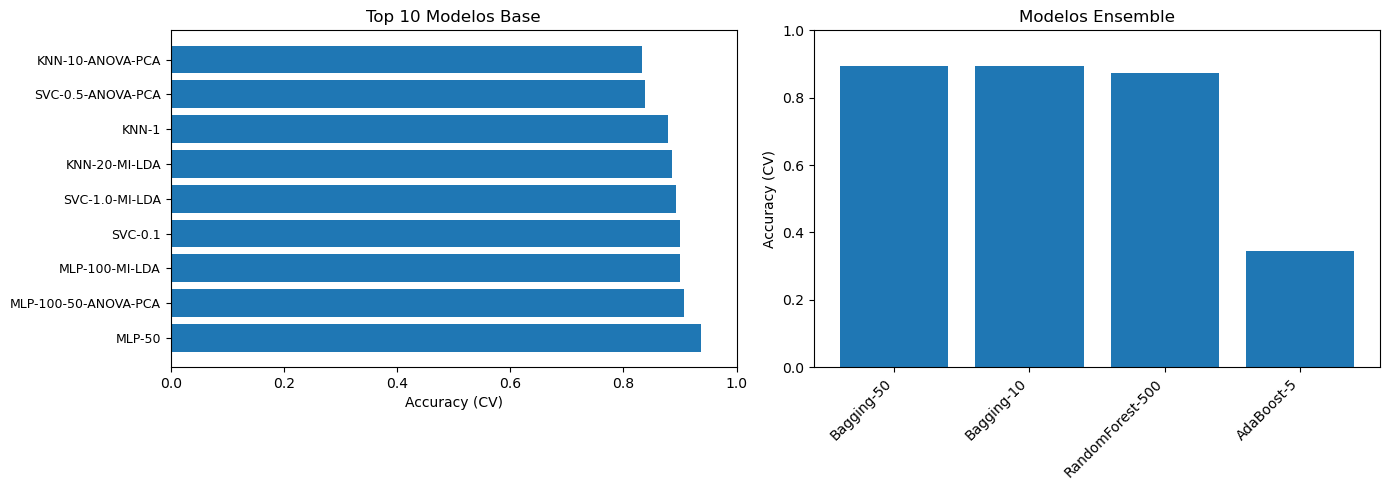


✓ Gráficos completados


In [23]:
# Gráficos comparativos finales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Modelos base (top 10)
top10 = df_base.head(10)
ax = axes[0]
x_pos = np.arange(len(top10))
ax.barh(x_pos, top10['mean_acc'])
ax.set_yticks(x_pos)
ax.set_yticklabels(top10['model'], fontsize=9)
ax.set_xlabel('Accuracy (CV)')
ax.set_title('Top 10 Modelos Base')
ax.set_xlim([0, 1])

# Ensemble
ax = axes[1]
x_pos = np.arange(len(df_ens))
ax.bar(x_pos, df_ens['mean_acc'])
ax.set_xticks(x_pos)
ax.set_xticklabels(df_ens['model'], rotation=45, ha='right')
ax.set_ylabel('Accuracy (CV)')
ax.set_title('Modelos Ensemble')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Gráficos completados")